### Урок 7. Кейс 2. Типы моделей для задачи тарификации

### -- Автор: Шенк Евгений Станиславович

### Домашнее задание (часть 2)

1. Придумать новые признаки (у нас их всего 5 было) - сделать дополнительный feature engineering
2. Для подходов с одной моделью поварьировать параметры CatBoostClassifier либо даже попробовать другой алгоритм (опционально уже). 
3. Для пункта 2 (подходов на основе одной модели) вывести значимость признаков, основываясь на model.estimator.feature_importances_ и model.estimator.feature_names_. 
4. Дополнить models_results дополнительными метриками (roc auc, logloss, f1). В конце вывести сводную таблицу всех показателей для всех подходов

Выполнение:
    1. Выполнено: выделены года, месяцы, дни и т.д. из обоих признаков с датами, взята их разница  
    2. Подобраны параметры (для удобства сравнения эти же параметры применены далее ко всем алгоритмам), и взят алгоритм LGBMClassifier  
    3. Выполнено  
    4. Добавлены различные метрики. Таблица вконце нотбука. Метрики оценивались по ctrl_preds_ (условные вероятности выполнения целевого действия без взаимодействия для каждого объекта), для всех кроме подхода с трансформацией классов, т.к. там не удалось найти функцию получения вероятностей. threshold взят 0,6.   

In [1]:
%matplotlib inline

import pandas as pd
#import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,f1_score,precision_score,recall_score,log_loss

from catboost import CatBoostClassifier
import lightgbm as lgbm

In [2]:
# Чтение данных
df_clients = pd.read_csv('./data/clients.csv', index_col='client_id')
df_train = pd.read_csv('./data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('./data/uplift_test.csv', index_col='client_id')

In [3]:
df_clients.head(5)

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


### feature engineering

In [4]:
df_features = df_clients.copy()

df_features['issue_year'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_issue_date'])).year
df_features['issue_month'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_issue_date'])).month
df_features['issue_quarter'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_issue_date'])).quarter
df_features['issue_dayofyear'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_issue_date'])).dayofyear
df_features['issue_weekofyear'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_issue_date'])).weekofyear
df_features['issue_dayofweek'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_issue_date'])).dayofweek
df_features['issue_hour'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_issue_date'])).hour

df_features['redeem_year'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_redeem_date'])).year
df_features['redeem_month'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_redeem_date'])).month
df_features['redeem_quarter'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_redeem_date'])).quarter
df_features['redeem_dayofyear'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_redeem_date'])).dayofyear
df_features['redeem_weekofyear'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_redeem_date'])).weekofyear
df_features['redeem_dayofweek'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_redeem_date'])).dayofweek
df_features['redeem_hour'] = pd.DatetimeIndex(pd.to_datetime(df_clients['first_redeem_date'])).hour

df_features['diff'] = (pd.to_datetime(df_clients['first_redeem_date']) - pd.to_datetime(df_clients['first_issue_date'])) // pd.Timedelta('1h')

#Label encoding Binary columns
le = LabelEncoder()
df_features['gender'] = le.fit_transform(df_features['gender'])

In [5]:
# Извлечение признаков
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, 
                                                test_size=0.4, 
                                                random_state=12)

In [6]:
df_clients['age'].describe()

count    400162.000000
mean         46.488112
std          43.871218
min       -7491.000000
25%          34.000000
50%          45.000000
75%          59.000000
max        1901.000000
Name: age, dtype: float64

In [7]:
df_clients['gender'].value_counts()

U    185706
F    147649
M     66807
Name: gender, dtype: int64

In [8]:
#признаки
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400162 entries, 000012768d to fffff6ce77
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 400162 non-null  int64  
 1   gender              400162 non-null  int32  
 2   issue_year          400162 non-null  int64  
 3   issue_month         400162 non-null  int64  
 4   issue_quarter       400162 non-null  int64  
 5   issue_dayofyear     400162 non-null  int64  
 6   issue_weekofyear    400162 non-null  int64  
 7   issue_dayofweek     400162 non-null  int64  
 8   issue_hour          400162 non-null  int64  
 9   redeem_year         364693 non-null  float64
 10  redeem_month        364693 non-null  float64
 11  redeem_quarter      364693 non-null  float64
 12  redeem_dayofyear    364693 non-null  float64
 13  redeem_weekofyear   364693 non-null  float64
 14  redeem_dayofweek    364693 non-null  float64
 15  redeem_hour         364693

Посмотрим, что же у нас за данные

In [9]:
df_train.head(3)

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1


In [10]:
df_train.groupby('treatment_flg')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,100058.0,0.603280,0.489219,0.0,0.0,1.0,1.0,1.0
1,99981.0,0.636511,0.481006,0.0,0.0,1.0,1.0,1.0


In [11]:
df_train['target'].value_counts()

1    124002
0     76037
Name: target, dtype: int64

Поле treatment_flg - было воздействие или нет.

Для удобства объявим некоторые переменные:

In [12]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'roc_auc_score': [],
    'log_loss': [],
    'f1_score': [],
}

threshold = 0.6

## 1. Подходы с одной моделью

### 1.1 Одна модель с признаком коммуникации

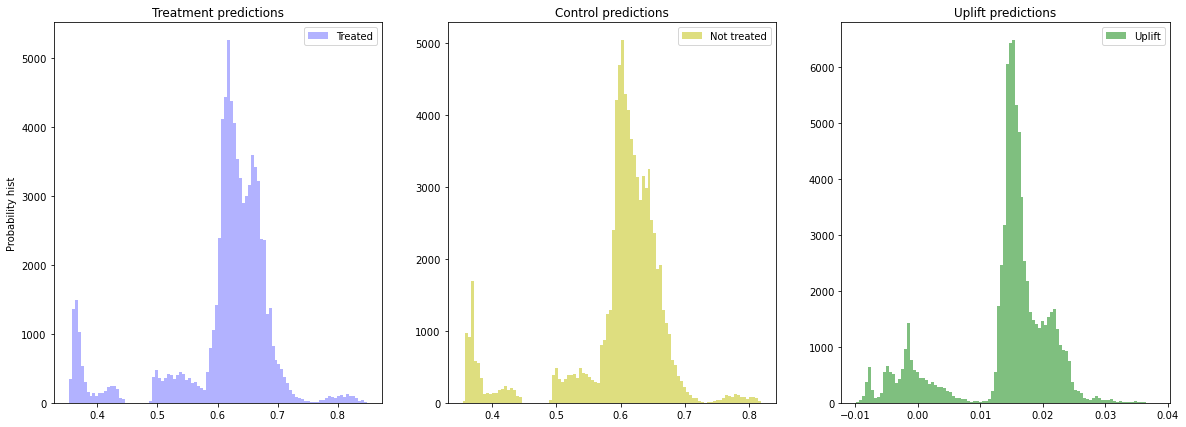

In [13]:
# CatBoostClassifier
sm_cat = SoloModel(CatBoostClassifier(iterations=200, learning_rate=0.01, depth=5, thread_count=2, random_state=123, silent=True))

sm_cat = sm_cat.fit(X_train, y_train, treat_train)

uplift_sm_cat = sm_cat.predict(X_val)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm_cat.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm_cat.ctrl_preds_

pred = [x>=threshold for x in sm_ctrl_preds]

sm_cat_score = uplift_at_k(y_true=y_val, uplift=uplift_sm_cat, treatment=treat_val, strategy='by_group', k=0.3)
accuracy     = accuracy_score(y_val,pred)
recallscore  = recall_score(y_val,pred)
precision    = precision_score(y_val,pred)
roc_auc      = roc_auc_score(y_val,pred)
logloss      = log_loss(y_val,pred)
f1score      = f1_score(y_val,pred)

models_results['approach'].append('SoloModel_Cat')
models_results['uplift@30%'].append(sm_cat_score)
models_results['accuracy'].append(accuracy)
models_results['recall'].append(recallscore)
models_results['precision'].append(precision)
models_results['roc_auc_score'].append(roc_auc)
models_results['log_loss'].append(logloss)
models_results['f1_score'].append(f1score)

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [14]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm_cat.estimator.feature_names_,
    'feature_score': sm_cat.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,50.194463
1,redeem_dayofyear,7.429003
2,redeem_quarter,6.113947
3,redeem_year,5.491563
4,redeem_hour,5.403415
5,issue_redeem_delay,4.608925
6,age,4.034071
7,redeem_month,3.603385
8,redeem_dayofweek,2.915657
9,redeem_weekofyear,2.677096


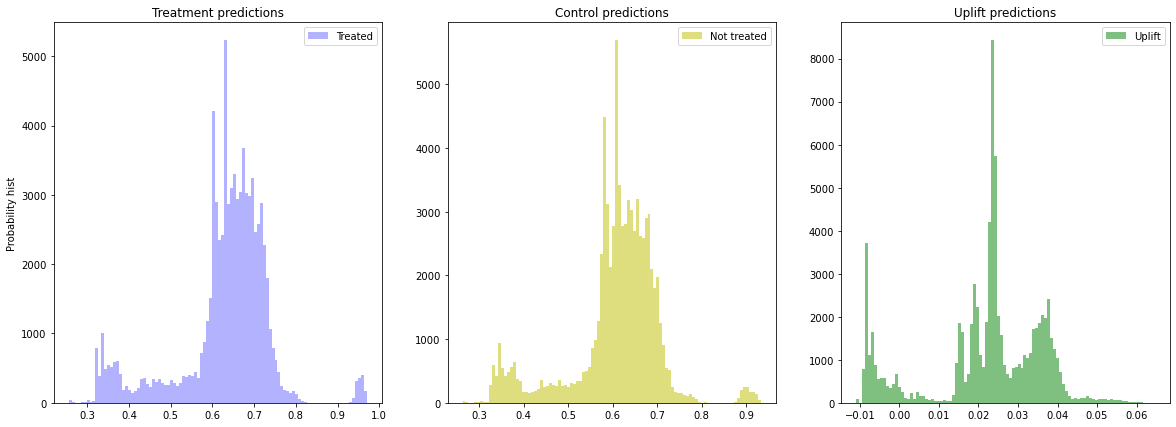

In [15]:
# LGBMClassifier
sm_lgbm = SoloModel(lgbm.LGBMClassifier(learning_rate = 0.01, max_depth = 50,  num_leaves = 5, n_estimators = 1000,
                                    subsample= 1, reg_alpha = 0, reg_lambda = 0, n_jobs=-1, random_state=123))

sm_lgbm = sm_lgbm.fit(X_train, y_train, treat_train)

uplift_sm_lgbm = sm_lgbm.predict(X_val)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm_lgbm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm_lgbm.ctrl_preds_

pred = [x>=threshold for x in sm_ctrl_preds]

sm_lgbm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm_lgbm, treatment=treat_val, strategy='by_group', k=0.3)
accuracy     = accuracy_score(y_val,pred)
recallscore  = recall_score(y_val,pred)
precision    = precision_score(y_val,pred)
roc_auc      = roc_auc_score(y_val,pred)
logloss      = log_loss(y_val,pred)
f1score      = f1_score(y_val,pred)

models_results['approach'].append('SoloModel_lgbm')
models_results['uplift@30%'].append(sm_lgbm_score)
models_results['accuracy'].append(accuracy)
models_results['recall'].append(recallscore)
models_results['precision'].append(precision)
models_results['roc_auc_score'].append(roc_auc)
models_results['log_loss'].append(logloss)
models_results['f1_score'].append(f1score)

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [16]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm_lgbm.estimator.booster_.feature_name(),
    'feature_score': sm_lgbm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,918
1,age,663
2,first_issue_time,590
3,diff,470
4,redeem_dayofyear,336
5,treatment,185
6,gender,165
7,issue_hour,163
8,issue_redeem_delay,150
9,redeem_hour,119


In [17]:
#посмотрим на models_results
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,accuracy,recall,precision,roc_auc_score,log_loss,f1_score
0,SoloModel_Cat,0.066275,0.608791,0.704304,0.678170,0.578284,13.512055,0.69099
1,SoloModel_lgbm,0.064610,0.609728,0.705552,0.678727,0.579122,13.479681,0.69188


### 1.2 Трансформация классов

In [18]:
from sklift.models import ClassTransformation


#ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ClassTransformation(CatBoostClassifier(iterations=200, learning_rate=0.01, depth=5, thread_count=2, random_state=123, silent=True))

ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)
models_results['accuracy'].append('---')
models_results['recall'].append('---')
models_results['precision'].append('---')
models_results['roc_auc_score'].append('---')
models_results['log_loss'].append('---')
models_results['f1_score'].append('---')

C:\Users\Eugene\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.



In [19]:
sm_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,50.239755
1,redeem_dayofyear,17.907921
2,redeem_weekofyear,12.431718
3,redeem_dayofweek,5.049664
4,redeem_quarter,2.481028
5,age,2.117053
6,redeem_year,1.409655
7,redeem_month,1.309607
8,first_issue_time,1.215739
9,issue_hour,0.875942


## 2. Подходы с двумя моделями

### 2.1 Две независимые модели

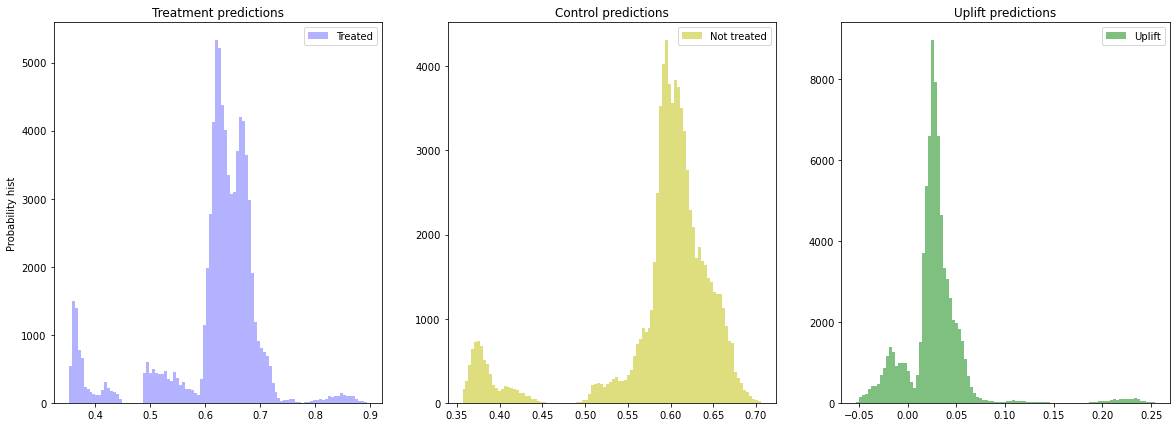

In [20]:
# iterations=20, thread_count=2, random_state=42, silent=True

from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=200, learning_rate=0.01, depth=5, thread_count=2, random_state=123, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=200, learning_rate=0.01, depth=5, thread_count=2, random_state=123, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

pred = [x>=threshold for x in tm.ctrl_preds_]

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
accuracy     = accuracy_score(y_val,pred)
recallscore  = recall_score(y_val,pred)
precision    = precision_score(y_val,pred)
roc_auc      = roc_auc_score(y_val,pred)
logloss      = log_loss(y_val,pred)
f1score      = f1_score(y_val,pred)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)
models_results['accuracy'].append(accuracy)
models_results['recall'].append(recallscore)
models_results['precision'].append(precision)
models_results['roc_auc_score'].append(roc_auc)
models_results['log_loss'].append(logloss)
models_results['f1_score'].append(f1score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 2.2 Две зависимые модели

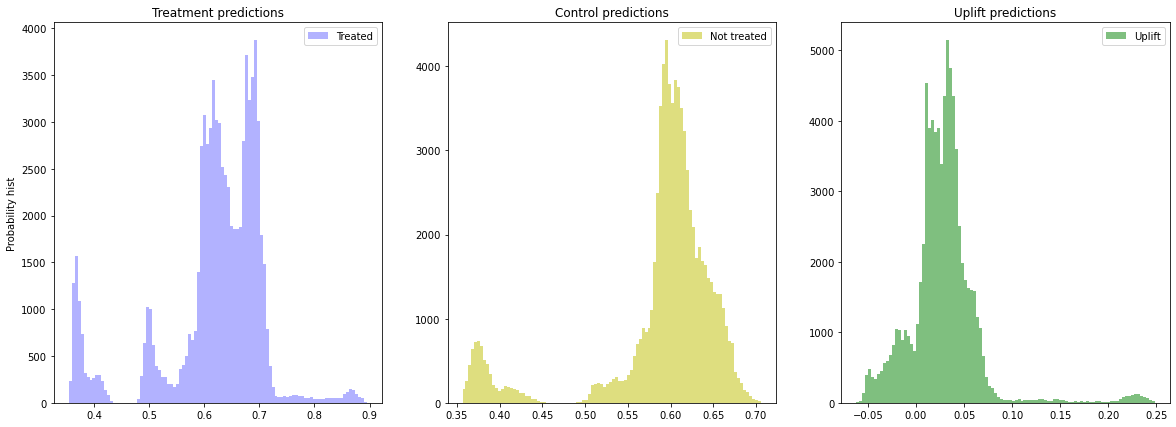

In [21]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=200, learning_rate=0.01, depth=5, thread_count=2, random_state=123, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=200, learning_rate=0.01, depth=5, thread_count=2, random_state=123, silent=True), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

pred = [x>=threshold for x in tm_ctrl.ctrl_preds_]

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, strategy='by_group', k=0.3)
accuracy     = accuracy_score(y_val,pred)
recallscore  = recall_score(y_val,pred)
precision    = precision_score(y_val,pred)
roc_auc      = roc_auc_score(y_val,pred)
logloss      = log_loss(y_val,pred)
f1score      = f1_score(y_val,pred)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)
models_results['accuracy'].append(accuracy)
models_results['recall'].append(recallscore)
models_results['precision'].append(precision)
models_results['roc_auc_score'].append(roc_auc)
models_results['log_loss'].append(logloss)
models_results['f1_score'].append(f1score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$.

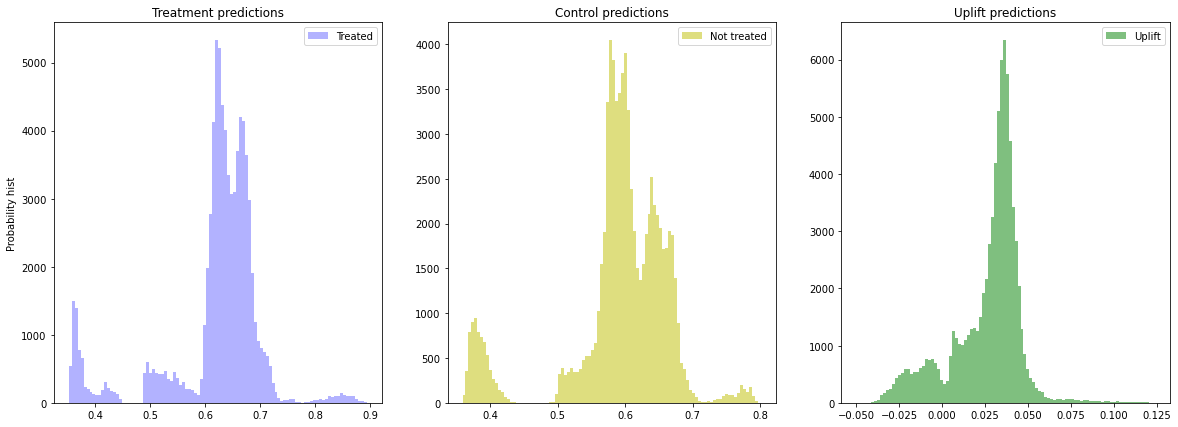

In [22]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=200, learning_rate=0.01, depth=5, thread_count=2, random_state=123, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=200, learning_rate=0.01, depth=5, thread_count=2, random_state=123, silent=True), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

pred = [x>=threshold for x in tm_trmnt.ctrl_preds_]

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, strategy='by_group', k=0.3)
accuracy     = accuracy_score(y_val,pred)
recallscore  = recall_score(y_val,pred)
precision    = precision_score(y_val,pred)
roc_auc      = roc_auc_score(y_val,pred)
logloss      = log_loss(y_val,pred)
f1score      = f1_score(y_val,pred)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)
models_results['accuracy'].append(accuracy)
models_results['recall'].append(recallscore)
models_results['precision'].append(precision)
models_results['roc_auc_score'].append(roc_auc)
models_results['log_loss'].append(logloss)
models_results['f1_score'].append(f1score)


plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

In [23]:
pd.DataFrame({
    'feature_name': tm_trmnt.estimator_ctrl.feature_names_,
    'feature_score': tm_trmnt.estimator_ctrl.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,ddr_treatment,48.115108
1,redeem_quarter,6.028409
2,issue_redeem_delay,6.016077
3,first_redeem_time,5.085464
4,redeem_hour,4.345673
5,redeem_dayofyear,4.300199
6,redeem_dayofweek,4.286999
7,redeem_year,4.281758
8,diff,3.565942
9,redeem_month,2.962789


In [24]:
pd.DataFrame({
    'feature_name': tm_trmnt.estimator_trmnt.feature_names_,
    'feature_score': tm_trmnt.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,first_redeem_time,58.171509
1,redeem_dayofyear,5.996379
2,redeem_year,5.941137
3,redeem_month,4.569324
4,redeem_weekofyear,4.298804
5,redeem_quarter,4.260247
6,age,4.013490
7,diff,3.929287
8,redeem_hour,2.156612
9,issue_redeem_delay,1.939946


## Выводы

Рассмотрим, какой метод лучше всего показал себя в этой задаче

In [25]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,accuracy,recall,precision,roc_auc_score,log_loss,f1_score
0,SoloModel_Cat,0.066275,0.608791,0.704304,0.67817,0.578284,13.5121,0.69099
1,SoloModel_lgbm,0.064610,0.609728,0.705552,0.678727,0.579122,13.4797,0.69188
2,ClassTransformation,0.064356,---,---,---,---,---,---
3,TwoModels,0.063177,0.583696,0.613185,0.68382,0.574277,14.3788,0.646579
4,TwoModels_ddr_control,0.057040,0.583696,0.613185,0.68382,0.574277,14.3788,0.646579
5,TwoModels_ddr_treatment,0.048560,0.567999,0.545831,0.693318,0.575079,14.9209,0.610798
